In [164]:
import os

# Set CPU count for numpyro multi-chain multi-thread
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import pickle
import itertools

import jax
# Enable x64 for JAX
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as np
import jax.random as jr
from jax import jit, lax

import numpy as onp
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy import units as u
from astropy.io import fits
from scipy.ndimage import binary_dilation

import zodiax as zdx
import dLux as dl
import optax
import zodiax as zdx
import jax.tree_util as jtu
import equinox as eqx
import optimistix as optx
from tqdm.notebook import tqdm

from dLux.utils import arcsec2rad as toRad
from dLux.utils import rad2arcsec as toArcsec
from dLuxWebbpsf.utils import grid_search
from dLuxWebbpsf import NIRCam

from synphot import SourceSpectrum
from synphot.models import BlackBodyNorm1D

def norm(data):
    return data/data.sum()

In [165]:
#plt.rcParams['image.cmap'] = 'inferno'

plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

cmap_inf = plt.colormaps["inferno"].copy()
cmap_inf.set_bad('black', 1.)
cmap_inf.set_under('black')
cmap_inf.set_over('black')

cmap_sei = plt.colormaps["seismic"].copy()
cmap_sei.set_bad('black', 1.)
cmap_sei.set_under('black')
cmap_sei.set_over('black')


plt.ioff()

### Get data from FITS files

In [166]:
def get_mask(data, x, y, size, *, dilate = False):
    xx, yy = np.array(np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1])))

    mask_x = (xx >= (x - size)) & (xx <= (x + size))
    mask_y = (yy >= (y - size)) & (yy <= (y + size))

    data_mask = np.where((mask_x & mask_y), 0, 1)

    if dilate:
        data_mask = np.logical_not(binary_dilation(np.logical_not(data_mask))).astype(data_mask.dtype)

    return data_mask

In [167]:
def read_fits(path, masks = None):
    hdul = fits.open(path)
    #hdul.info()

    webbpsf_header = hdul[0].header
    webbpsf_data_star = np.array(sum(hdul[1].data))
    webbpsf_data_err = np.array(sum(hdul[2].data))
    webbpsf_data_dq = np.array(sum(hdul[3].data))

    hdul.close()

    # cleanup data
    webbpsf_data_star = np.where(np.isnan(webbpsf_data_star), 0, webbpsf_data_star)
    xx, yy = np.array(np.meshgrid(np.arange(webbpsf_data_star.shape[0]), np.arange(webbpsf_data_star.shape[1])))

    bri_y, bri_x = np.unravel_index(webbpsf_data_star.argmax(), webbpsf_data_star.shape)

    webbpsf_data_mask = get_mask(webbpsf_data_star, bri_x, bri_y, 2)

    if masks is not None:
        for (m_x, m_y, m_s) in masks:
            webbpsf_data_mask *= get_mask(webbpsf_data_star, m_x, m_y, m_s)

    webbpsf_data_mask = np.logical_not(binary_dilation(np.logical_not(webbpsf_data_mask))).astype(webbpsf_data_mask.dtype)
    webbpsf_data_mask *= (webbpsf_data_dq == 0) & ~((xx == 9) & (yy == 31)) # 9,31 is a hot pixel


    return webbpsf_header, webbpsf_data_star, webbpsf_data_mask, webbpsf_data_err

In [168]:
import itertools
import jax.numpy as np


def triu_indices(N, order=2):
    """
    Generates the upper triangle indices of an n-dimensional array.

    Args:
        arr (ndarray): The input array.

    Returns:
        tuple: A tuple of n arrays containing the indices of the upper triangle.
    """
    # Get the shape of the array
    shape = (N,) * order

    # Generate all the combinations of indices
    indices = itertools.product(*[range(s) for s in shape])

    # Filter the indices to keep only the upper triangle
    upper_triangle_indices = filter(
        lambda x: all(x[i] <= x[i + 1] for i in range(len(x) - 1)), indices
    )

    # Convert the filtered indices to arrays
    triangle_indices = zip(*upper_triangle_indices)
    triangle_indices = [np.array(indices) for indices in triangle_indices]

    return np.array(tuple(triangle_indices))


N = 9
order = 1
combinations = triu_indices(N, order)
print(combinations.shape)

import math

print(math.comb(order + N - 1, N - 1))

(1, 9)
9


In [169]:
from jax import vmap

vmap2d_ij = lambda fn: vmap(vmap(fn, (0, None)), (None, 0))
vmap2d_im = lambda fn: vmap(vmap(fn, (0,)), (1,))


class PolyBFE(dl.layers.detector_layers.DetectorLayer):
    order: int
    ksize: int
    coeffs: dict

    def __init__(self, ksize, order=3):
        self.ksize = int(ksize)
        self.order = int(order)
        if self.ksize % 2 != 1:
            raise ValueError("ksize must be odd")

        N = self.ksize**2
        coeffs = {"0": np.zeros((N, N))}
        for i in range(self.order):
            N_coeffs = triu_indices(self.ksize**2, i + 1).shape[1]
            idx = str(i + 1)
            coeffs[idx] = np.zeros((N, N_coeffs))
        self.coeffs = coeffs

    @property
    def k(self):
        return self.ksize // 2

    def arr_kernel(self, arr, i, j):
        """Returns a square of size (ksize, ksize) centred on the pixel (i,j)."""
        padded = np.pad(arr, (self.k, self.k))
        start = (i - self.k, j - self.k)
        size = (self.ksize, self.ksize)
        return jax.lax.dynamic_slice(padded, start, size)

    def build_basis(self, arr_kernel):
        """Builds the polynomial basis from an (ksize, ksize) shaped array kernel.
        Note we only support order = 2 for now, and this is the function that would
        need to modified to support other orders."""

        # Get our data vector
        x = arr_kernel.flatten()
        components = [np.ones_like(x)]  # Zeroth order is just a constant

        # Iterate over orders and append the components
        for i in range(1, self.order + 1):
            inds = triu_indices(self.ksize**2, i)
            prods = np.prod(np.array([x[ind] for ind in inds]), axis=0)
            components.append(prods)
        return np.concatenate(components)

    def eval_pixel(self, basii, arr_kernels, i, j):
        """Dimensionality is hard - Here we want to evaluate the 'migration' kernel of
        a single pixel, given the polynomial basis for that pixel, and the coefficients
        for the charge migration. Given this we can vectorise this function over each
        pixel in the input array to get the full migration kernel. It is easier to
        vectorise over a 1d array, and our basis vectors/coefficients are given in 1d,
        so we evaluate it in 1d here, and reshape the output to (ksize, ksize) so we
        have the correct output dimensions to apply to the image. We can also apply the
        flux conservation easily here."""
        basis = basii[j, i]
        arr_kernel = arr_kernels[i, j]

        # migrated_charge = vmap(lambda c: np.dot(basis, c))(self.coeffs)
        migrated_charge = vmap(lambda c: np.dot(basis, c))(self.coeffs_vec)
        migrated_charge -= migrated_charge.mean()
        migrated_charge = migrated_charge.reshape((self.ksize, self.ksize))
        return arr_kernel + migrated_charge

    @property
    def coeffs_vec(self):
        arrs = []
        for i in range(self.order + 1):
            arrs.append(self.coeffs[str(i)])
        return np.concatenate(arrs, axis=1)
        # print(arr.shape)
        # keys = sorted(self.coeffs.keys())
        # print(keys)
        # return np.concatenate([c.flatten() for c in self.coeffs.values()])

    def build(self, array):
        # Build the array kernels - individual shape (ksize, ksize),
        # output shape (N, N, ksize, ksize). These are the array kernels that the
        # polynomials are applied to
        Is = np.arange(array.shape[0])
        arr_kernels = vmap2d_ij(lambda i, j: self.arr_kernel(array, i, j))(Is, Is)

        # Build the polynomial basis
        basis = vmap2d_im(self.build_basis)(arr_kernels)

        # Evaluate the polynomial basis
        eval_pixel_fn = lambda i, j: self.eval_pixel(basis, arr_kernels, i, j)
        out = vmap2d_ij(eval_pixel_fn)(Is, Is)

        # eval_fn = vmap(vmap(self.eval_pixel, (0, 0)), (1, 1))
        # out = eval_fn(basis, arr_kernels)
        return out

    # Get indexes
    def build_indexs(self, i, j):
        """Built this like a year ago, literally no idea what is happening here."""
        vals = np.arange(self.ksize)
        xs, ys = np.tile(vals, self.ksize), np.repeat(vals, self.ksize)
        out = np.array([xs, ys]).T
        inv_out = np.flipud(out)
        out_shift = out + np.array([i, j])
        return np.concatenate([out_shift, inv_out], 1)

    def build_and_mean(self, array, i, j):
        indexes = self.build_indexs(j, i)
        return vmap(lambda x, i: x[tuple(i)], in_axes=(None, 0))(array, indexes).mean()

    def apply_BFE(self, array):
        kernels = self.build(array)
        kernels = np.pad(kernels, ((self.k, self.k), (self.k, self.k), (0, 0), (0, 0)))

        # Bind the kernels to the function for a simple vmap signature
        mean_fn = lambda i, j: self.build_and_mean(kernels, i, j)

        # Take the mean of the migrated charge
        Is = np.arange(array.shape[0]) + 1
        return vmap2d_ij(mean_fn)(Is, Is)

    def apply(self, PSF):
        # Pad the input to avoid edge artifacts
        pad = 1 + self.k
        array = np.pad(PSF.data, (pad, pad))
        BFEd = self.apply_BFE(array)
        return PSF.set("data", BFEd[pad:-pad, pad:-pad])

### Create model

In [196]:
zernike_terms=3
n_mirrors = 18
n_coeffs = n_mirrors * zernike_terms

def get_telescope(npix, filter, detector, aperture, opd_date, *, pixel_mask = None, flux=1e9, downsample=8, contrast=100, source=None):
    webb_options = {
        'add_distortion': True,
        'add_ipc': True,
        'dl_add_rotation': True,
        'dl_add_siaf': True,
        'dl_add_diffusion': True,
    }

    oversample = 4
    
    telescope = NIRCam(
                    filter = filter,
                    detector = detector,
                    aperture = aperture,
                    fft_oversample=1,
                    detector_oversample=oversample,
                    wavefront_downsample=downsample,
                    fov_pixels=npix,
                    options=webb_options,
                    phase_retrieval_terms = zernike_terms,
                    flux = flux,
                    load_opd_date=opd_date,
                    source = source
                )

    if pixel_mask is not None:
        response_layer = dl.ApplyPixelResponse(pixel_mask)
        telescope.detector.layers["pixel_mask"] = response_layer

    spectrum = dl.Spectrum(telescope.filter_wavelengths, telescope.filter_weights)
    source_pri = dl.PointSource(wavelengths=telescope.filter_wavelengths, spectrum=spectrum, flux=flux)
    source_sec = dl.PointSource(wavelengths=telescope.filter_wavelengths, spectrum=spectrum, flux=flux/contrast)

    source = dl.Scene([('pri', source_pri), ('sec', source_sec)])

    telescope = telescope.set(["source"], [source])


    optics = telescope.optics

    # Remove FDA - We will recover those directly
    # optics = optics.remove_layer("aberrations")

    # Normalise basis to nm
    # optics = optics.multiply('basis', 1e-9)
    
    # Update the detector
    detector = telescope.detector

    # Remove the SIAF distortion, we model this as affine transforms on the AMI mask
    # detector = detector.remove_layer('SIAF')

    # Remove the IPC kernel, we will absorb this into Charge Diffusion/
    # detector = detector.remove_layer('IPC')

    # Remove the existing oversampled charge diffusion layer
    # detector = detector.remove_layer('ChargeDiffusion')

    # Use parametric BFE model
    # detector = detector.insert_layer(("ChargeDiffusion", ApplyBFE(Gauss([0, 1e-1], 5))), 2)
    # detector = detector.insert_layer(("ChargeDiffusion", ApplyBFE(Gauss([-1e6, 1e-1], 5))), 2)
    
    #detector = detector.insert_layer(("BFE", PolyBFE(3, order=2)), 2)

    # # Make the second detector layer the Pixel Anisotropy layer (after rotation)
    # detector = detector.insert_layer(('pscale', ApplyAnisotropy()), 1)

    # Add free-floating detector background value
    detector = detector.insert_layer(('bg', dl.AddConstant(0.)), 3)

    # # Add 1/f noise model
    # order = 2 # linear
    # coeffs = np.zeros((64*oversample, order))
    # detector = detector.insert_layer(('OneOnF', AmplifierNoise(coeffs)), 4)
    
    # Re-combine the telescope
    telescope = telescope.set(["optics", "detector"], [optics, detector])
    

    return telescope

In [171]:
def crop(data):
    s = 10
    return data[s:-s, s:-s]

In [172]:
@zdx.filter_jit
def likelihood(model, pri_x, pri_y, sec_x, sec_y, expected_data):
    
    model_data_n = model.set(['source.pri.position', 'source.sec.position'],
                             [np.array([pri_x, pri_y]), np.array([sec_x, sec_y])]).model()
    
    model_data = norm(model_data_n)
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared
    return likelihood

@zdx.filter_jit
def likelihood_fast(telescope, pri_x, pri_y, sec_x, sec_y, expected_data):
    likelihood_c = lambda args : likelihood(telescope, args[0], args[1], args[2], args[3], expected_data)

    args = np.stack((pri_x, pri_y, sec_x, sec_y), axis=-1)
    return lax.map(likelihood_c, args)

In [188]:
def search_grid(model, data, *, iters = 20, steps = 30,
                pri_xr = None, pri_yr = None, sec_xr = None, sec_yr = None,
                pri_width = toRad(1), sec_width = toRad(1), plot = False
):

    @zdx.filter_jit
    def get_single(xr, yr):
        return likelihood_fast(model, xr, yr, xr, yr, data)

    @zdx.filter_jit
    def get_primary(xr, yr):
        return likelihood_fast(model, xr, yr, np.full_like(xr, sec_xr), np.full_like(yr, sec_yr), data)

    @zdx.filter_jit
    def get_secondary(xr, yr):
        return likelihood_fast(model, np.full_like(xr, pri_xr), np.full_like(yr, pri_yr), xr, yr, data)
    
    steps = 30

    i = 0

    pri_xr, pri_yr, tp = grid_search(get_single, pri_xr, pri_yr, pri_width, steps, niter = 3)

    if sec_xr is None:
        sec_xr = pri_xr
        
    if sec_yr is None:
        sec_yr = pri_yr

    sec_xr, sec_yr, ts = grid_search(get_secondary, sec_xr, sec_yr, sec_width, steps, niter = 1)

    plt.show()

    while i < iters:
        print(f'Grid search step {i}')

        pri_xr, pri_yr, tp = grid_search(get_primary, pri_xr, pri_yr, pri_width, steps, niter = 1)
        
        print(f'Grid search step {i} - primary')
        sec_xr, sec_yr, ts = grid_search(get_secondary, sec_xr, sec_yr, sec_width, steps, niter = 1)
        
        print(f'Grid search step {i} - secondary')

        if plot:
            plt.subplot(1, 2, 1)
            plt.imshow(tp[0]['likelihoods'], origin='lower')
            plt.subplot(1, 2, 2)
            plt.imshow(ts[0]['likelihoods'], origin='lower')
            plt.show()
        
        pri_width = pri_width * 2. / 3.
        sec_width = sec_width * 4. / 5.
        
        i += 1

    return pri_xr, pri_yr, sec_xr, sec_yr

In [174]:
def fit_image(
    model,
    args,
    loss_fn,
    # grad_fn,
    norm_fn,
    epochs,
    config,
    verbose=True,
    print_grads=False,
):
    params = list(config.keys())
    optimisers = list(config.values())

    model = zdx.set_array(model, params)
    optim, opt_state = zdx.get_optimiser(model, params, optimisers)

    # if verbose:
    #     print("Compiling...")
    loss, grads = loss_fn(model, args)
    if print_grads:
        for param in params:
            print(f"{param}: {grads.get(param)}")
    losses, models_out = [], [model]

    if verbose:
        looper = tqdm(range(epochs), desc="Loss %.2f" % (loss))
    else:
        looper = range(epochs)

    for i in looper:
        # calculate the loss and gradient
        loss, grads = loss_fn(model, args)
        
        if print_grads:
            for param in params:
                print(f"{param}: {grads.get(param)}")
                
        if np.isnan(loss):
            print(f"Loss is NaN on {i} th epoch")
            return losses, models_out

        # # Apply any processing to the gradients
        # grads = grad_fn(grads, config, i)

        # apply the update
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        # Apply normalisation
        model = norm_fn(model)

        # save results
        models_out.append(model)
        losses.append(loss)

        if verbose:
            looper.set_description("Loss %.2E" % (loss))

    return losses, models_out

In [175]:
def format_fn(params_out, param):
    arr = np.array(params_out[param])
    if param == "position":
        return arr - arr[0]
    if "coefficient" in param:
        return arr.reshape(len(arr), -1)
    if "IPC.kernel" in param:
        arr = arr.at[:, 2, 2].add(-1)
        return arr.reshape(len(arr), -1)
    if "BFE.coeffs" in param:
        return arr.reshape(len(arr), -1)
    if "pupil_mask.holes" in param:
        arr = arr.reshape(len(arr), -1)
        return arr - arr[0]
    if 'OneOnF' in param:
        return arr.reshape(len(arr), -1)

    return arr

In [176]:
def plot_params(losses, params_out, format_fn, k=10, l=-1):
    # nparams = len(params_out.keys())
    # nplots = (nparams + 1) // 2

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.title("Full Loss")
    plt.plot(losses)

    if k >= len(losses):
        k = 0
    last_losses = losses[k:l]
    n = len(last_losses)
    plt.subplot(1, 2, 2)
    plt.title(f"Final {n} Losses")
    plt.plot(np.arange(k, k + n), last_losses)

    plt.tight_layout()
    plt.show()

    params = list(params_out.keys())
    for i in np.arange(0, len(params), 2):
        plt.figure(figsize=(16, 5))
        plt.subplot(1, 2, 1)
        plt.title(params[i])
        plt.plot(format_fn(params_out, params[i]))

        plt.subplot(1, 2, 2)
        if i + 1 == len(params):
            plt.tight_layout()
            plt.show()
            break
        plt.title(params[i + 1])
        plt.plot(format_fn(params_out, params[i + 1]))

        plt.tight_layout()
        plt.show()

In [177]:
def nan_edges(im, edge_mask):
    im = im.at[:edge_mask].set(np.nan)
    im = im.at[-edge_mask:].set(np.nan)
    im = im.at[:, :edge_mask].set(np.nan)
    im = im.at[:, -edge_mask:].set(np.nan)
    return im

In [178]:
# Normalise the various components of the model
def norm_fn(model):
    return model

## Step 4: Make plots.

In [179]:
def get_aber(coeffs, basis):
    s_coeffs = np.asarray(coeffs.reshape(coeffs.shape[0], 1, 1), dtype=float)
    s_basis = np.asarray(basis, dtype=float)
    result = s_coeffs * s_basis
    return result.sum(0)

In [180]:
def double_plot(a, b, title, filename):
    fig = plt.figure(figsize=(8, 3))
    plt.suptitle(title)
    
    plt.subplot(1, 2, 1)
    plt.imshow(a, norm='log')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(b)
    plt.colorbar()

    plt.savefig(filename)
    plt.close(fig)

In [181]:
def plot_residuals(a, b, title, filename, points = None, text = None, pixscale = 1):

    centre_a = len(a)/2
    centre_b = len(b)/2
    extent = [-centre_a*pixscale, centre_a*pixscale, -centre_b*pixscale, centre_b*pixscale]

    fig = plt.figure(figsize=(12, 10))

    plt.suptitle(title)

    ax1 = plt.subplot(2, 2, 1)
    #ax1.set(xticks=np.linspace(0, 120, 7), xticklabels=np.arange(0, 121, 20), yticks=[0, 10], yticklabels=[0, 1])
    #ax1.set(xticks=xvals, xticklabels=np.arange(0, len(a), 20), yticks=xvals)

    plt.imshow(a, norm='log', cmap=cmap_inf, extent=extent)
    plt.xlabel("$\Delta$x, arcsec", fontsize=20)
    plt.ylabel("$\Delta$y, arcsec", fontsize=20)
    plt.colorbar().set_label("Normalized flux")
    plt.title("Data")

    if (points is not None):
        for x, y, s in points:
            plt.plot(x, y, marker=s, color="red")

    ax2 = plt.subplot(2, 2, 2)

    plt.imshow(b, norm='log', cmap=cmap_inf, extent=extent)
    plt.xlabel("$\Delta$x, arcsec", fontsize=20)
    plt.ylabel("$\Delta$y, arcsec", fontsize=20)
    plt.colorbar().set_label("Normalized flux")
    plt.title("Model")

    if (points is not None):
        for x, y, s in points:
            plt.plot(x, y, marker=s, color="red")

    delta = a - b
    vlim = np.nanmax(np.abs(delta))

    ax3 = plt.subplot(2, 2, 3)
    plt.imshow(a - b, vmin=-vlim, vmax=vlim, cmap=cmap_sei, extent=extent)
    plt.xlabel("$\Delta$x, arcsec", fontsize=20)
    plt.ylabel("$\Delta$y, arcsec", fontsize=20)
    plt.colorbar()
    plt.title("Residual")

    if (points is not None):
        for x, y, s in points:
            plt.plot(x, y, marker=s, color="red")
    
    residual = a - b
    #rel_resid = residual / a**0.5
    rel_resid = residual / b**0.5

    
    vlim_r = np.nanmax(np.abs(rel_resid))

    ax4 = plt.subplot(2, 2, 4)
    #plt.imshow(rel_resid, cmap=cmap)
    #plt.imshow(rel_resid, vmin=-(np.nanmax(rel_resid)*2), cmap=cmap_sei)
    plt.imshow(rel_resid, vmin=-vlim_r, vmax=vlim_r, cmap=cmap_sei, extent=extent)
    plt.xlabel("$\Delta$x, arcsec", fontsize=20)
    plt.ylabel("$\Delta$y, arcsec", fontsize=20)
    plt.colorbar()
    plt.title("Relative residual")
    #plt.title("Relative residual ((data - model)/data**0.5)")
    
    if points is not None:
        for x, y, s in points:
            plt.plot(x, y, marker=s, color="red")

    if text is not None:
        plt.figtext(0.25, 0.01, text)

    plt.savefig(filename)
    plt.close(fig)

## Run All

In [182]:
base_path = '~/JWST/data/JWSTGO1902/calints/'
ouput_path = '~/JWST/results_single/'
pickle_dir = ouput_path

os.makedirs(ouput_path, exist_ok=True)
os.makedirs(pickle_dir, exist_ok=True)


files_all = [
    (('HD 135067', 'NRCB1', 'F212N'), '../data/JWSTGO1902/calints/jw01902002001_0210e_00001_nrcb1_calints.fits'),
    (('HD 135067', 'NRCB1', 'F187N'), '../data/JWSTGO1902/calints/jw01902002001_02108_00001_nrcb1_calints.fits'),
    (('HD 135067', 'NRCBLONG', 'F444W'), '../data/JWSTGO1902/calints/jw01902002001_02108_00001_nrcblong_calints.fits'),
    (('HD 135067', 'NRCBLONG', 'F444W'), '../data/JWSTGO1902/calints/jw01902002001_0210e_00001_nrcblong_calints.fits'),
    (('HD 135067', 'NRCBLONG', 'F322W2'), '../data/JWSTGO1902/calints/jw01902002001_02102_00001_nrcblong_calints.fits'),
    (('HD 135067', 'NRCB1', 'F150W2'), '../data/JWSTGO1902/calints/jw01902002001_02102_00001_nrcb1_calints.fits'),
    (('HD 136164', 'NRCB1', 'F212N'), '../data/JWSTGO1902/calints/jw01902001001_0210e_00001_nrcb1_calints.fits'),
    (('HD 136164', 'NRCB1', 'F187N'), '../data/JWSTGO1902/calints/jw01902001001_02108_00001_nrcb1_calints.fits'),
    (('HD 136164', 'NRCBLONG', 'F444W'), '../data/JWSTGO1902/calints/jw01902001001_0210e_00001_nrcblong_calints.fits'),
    (('HD 136164', 'NRCBLONG', 'F444W'), '../data/JWSTGO1902/calints/jw01902001001_02108_00001_nrcblong_calints.fits'),
    (('HD 136164', 'NRCBLONG', 'F322W2'), '../data/JWSTGO1902/calints/jw01902001001_02102_00001_nrcblong_calints.fits'),
    (('HD 136164', 'NRCB1', 'F150W2'), '../data/JWSTGO1902/calints/jw01902001001_02102_00001_nrcb1_calints.fits'),
]

files = [f for k, f in files_all]


In [183]:
for fits_path in files:

    webbpsf_header, webbpsf_data_star, webbpsf_data_mask, webbpsf_data_err = read_fits(fits_path)

    filter_name = webbpsf_header["FILTER"] if webbpsf_header["PUPIL"] == "CLEAR" else webbpsf_header["PUPIL"]

    key_names = ["TARGNAME", "DETECTOR", "FILTER", "PUPIL" ]
    target_key = ' '.join(list([webbpsf_header[k] for k in key_names]))

    print(target_key, filter_name)

HD 135067 NRCB1 F212N CLEAR F212N
HD 135067 NRCB1 F187N CLEAR F187N
HD 135067 NRCBLONG F444W F405N F405N
HD 135067 NRCBLONG F444W F470N F470N
HD 135067 NRCBLONG F322W2 F323N F323N
HD 135067 NRCB1 F150W2 F164N F164N
HD 136164 NRCB1 F212N CLEAR F212N
HD 136164 NRCB1 F187N CLEAR F187N
HD 136164 NRCBLONG F444W F470N F470N
HD 136164 NRCBLONG F444W F405N F405N
HD 136164 NRCBLONG F322W2 F323N F323N
HD 136164 NRCB1 F150W2 F164N F164N


Creating model...
MAST OPD query around UTC: 2023-02-19T15:18:08.320
                        MJD: 59994.6375962963

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2023021903-NRCA3_FP1-1.fits
	Date (MJD):	 59994.0235
	Delta time:	 -0.6141 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2023022103-NRCA3_FP1-1.fits
	Date (MJD):	 59995.9079
	Delta time:	 1.2703 days
User requested choosing OPD time closest in time to 2023-02-19T15:18:08.320, which is R2023021903-NRCA3_FP1-1.fits, delta time -0.614 days
Importing and format-converting OPD from /root/JWST/webbpsf-data/MAST_JWST_WSS_OPDs/R2023021903-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
ok
Grid search...Grid search step 0
Grid search step 0 - primary
Grid search step 0 - secondary


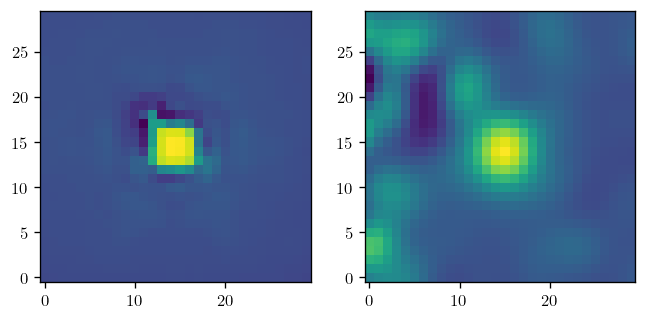

Grid search step 1
Grid search step 1 - primary
Grid search step 1 - secondary


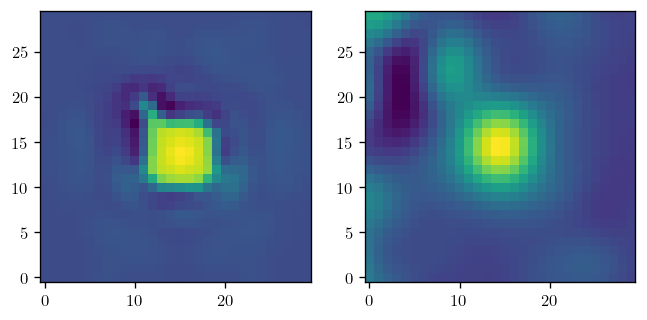

Grid search step 2
Grid search step 2 - primary
Grid search step 2 - secondary


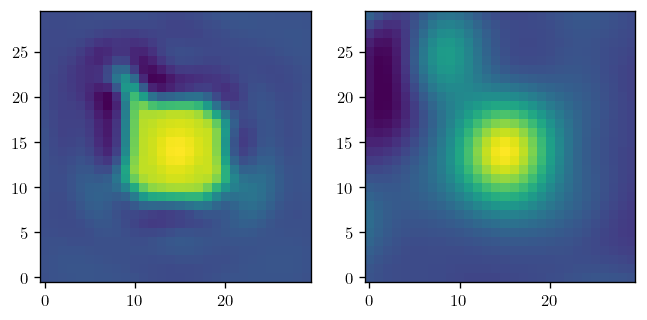

Grid search step 3
Grid search step 3 - primary
Grid search step 3 - secondary


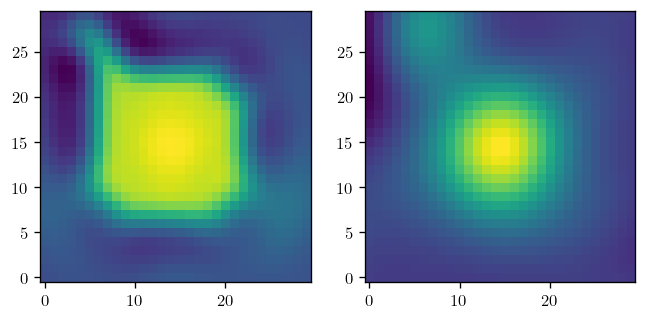

Grid search step 4
Grid search step 4 - primary
Grid search step 4 - secondary


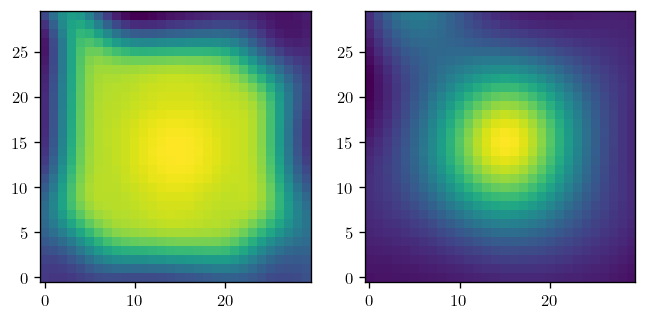

64
ok


In [190]:
for fits_path in files[:1]:

    webbpsf_header, webbpsf_data_star, webbpsf_data_mask, webbpsf_data_err = read_fits(fits_path)

    npix = webbpsf_data_star.shape[0]
    webbpsf_data_flux = np.float64(np.sum(webbpsf_data_star))
    webbpsf_data_masked = webbpsf_data_star * webbpsf_data_mask

    key_names = ["TARGNAME", "DETECTOR", "FILTER", "PUPIL" ]
    target_key = ' '.join(list([webbpsf_header[k] for k in key_names]))

    grid_search_filename = os.path.join(pickle_dir, target_key + " GRID SEARCH DATA.bin")
    hmc_filename = os.path.join(pickle_dir, target_key + " HMC DATA.bin")
    pickle_file = os.path.join(pickle_dir, target_key + ".bin")

    double_plot(webbpsf_data_masked, webbpsf_data_mask, target_key, os.path.join(ouput_path, target_key + ' 1 DATA'))
    # continue

    print('Creating model...', end="")

    telescope = get_telescope(npix,
                            webbpsf_header["FILTER"] if webbpsf_header["PUPIL"] == "CLEAR" else webbpsf_header["PUPIL"],
                            webbpsf_header['DETECTOR'].replace('LONG', '5'),
                            webbpsf_header['APERNAME'],
                            webbpsf_header['DATE-BEG'],
                            downsample = 8,
                            contrast=250,
                            flux = webbpsf_data_flux,
                            pixel_mask = webbpsf_data_mask
                            )

    pixscale = toRad(telescope.psf_pixel_scale)

    print("ok")

    print('Grid search...', end="")
    grid_data = None

    if os.path.isfile(grid_search_filename):
        with open(grid_search_filename, "rb") as f:
            grid_data = pickle.load(f)
    else:
        pri_xr, pri_yr, sec_xr, sec_yr = search_grid(telescope, norm(webbpsf_data_masked), sec_xr=toRad(0.5), sec_yr=toRad(-0.25), sec_width = toRad(0.5), steps=30, iters=5, plot=True)
        
        recovered_data = telescope.set(['source.pri.position', 'source.sec.position'],
                                   [np.array([pri_xr, pri_yr]), np.array([sec_xr, sec_yr])]).model()

        grid_data = {
            'data': norm(webbpsf_data_masked),
            'model': norm(recovered_data),
            'pri_x': pri_xr,
            'pri_y': pri_yr,
            'sec_x': sec_xr,
            'sec_y': sec_yr
        }

        with open(os.path.join(pickle_dir, target_key + " GRID SEARCH DATA.bin"), "wb") as f:
            pickle.dump(grid_data, f)


    (pri_xr, pri_yr), (sec_xr, sec_yr) =  (grid_data['pri_x'], grid_data['pri_y']), (grid_data['sec_x'], grid_data['sec_y'])
    
    star_points = [
        (toArcsec(pri_xr), toArcsec(pri_yr), '*'),
        (toArcsec(sec_xr), toArcsec(sec_yr), '.')
    ]

    plot_residuals(norm(webbpsf_data_masked), norm(recovered_data),
                target_key + " GRID SEARCH RESIDUALS", os.path.join(ouput_path, target_key + ' 2 GRID SEARCH'),
                points = star_points, pixscale=telescope.psf_pixel_scale)

    print("ok")

In [185]:
for fits_path in files[:1]:

    webbpsf_header, webbpsf_data_star, webbpsf_data_mask, webbpsf_data_err = read_fits(fits_path)

    npix = webbpsf_data_star.shape[0]
    webbpsf_data_flux = np.float64(np.sum(webbpsf_data_star))
    webbpsf_data_masked = webbpsf_data_star * webbpsf_data_mask

    key_names = ["TARGNAME", "DETECTOR", "FILTER", "PUPIL" ]
    target_key = ' '.join(list([webbpsf_header[k] for k in key_names]))

    grid_search_filename = os.path.join(pickle_dir, target_key + " GRID SEARCH DATA.bin")
    hmc_filename = os.path.join(pickle_dir, target_key + " HMC DATA.bin")
    pickle_file = os.path.join(pickle_dir, target_key + ".bin")

    # double_plot(webbpsf_data_masked, webbpsf_data_mask, target_key, os.path.join(ouput_path, target_key + ' 1 DATA'))
    # continue

    print('Creating model...', end="")

    #spectrum = SourceSpectrum(BlackBodyNorm1D, temperature=7500)

    telescope = get_telescope(npix,
                            webbpsf_header["FILTER"] if webbpsf_header["PUPIL"] == "CLEAR" else webbpsf_header["PUPIL"],
                            webbpsf_header['DETECTOR'].replace('LONG', '5'),
                            webbpsf_header['APERNAME'],
                            webbpsf_header['DATE-BEG'],
                            #pixel_mask = webbpsf_data_mask,
                            downsample = 4,
                            flux = webbpsf_data_flux,
                            #source=spectrum
                            )

    pixscale = toRad(telescope.psf_pixel_scale)

    print("ok")

    if os.path.isfile(grid_search_filename):
        with open(grid_search_filename, "rb") as f:
            grid_data = pickle.load(f)
    else:
        raise Exception("No grid search data, run grid search first")

    (pri_xr, pri_yr), (sec_xr, sec_yr) =  (grid_data['pri_x'], grid_data['pri_y']), (grid_data['sec_x'], grid_data['sec_y'])
     
    star_points = [
        (toArcsec(pri_xr), toArcsec(pri_yr), '*'),
        (toArcsec(sec_xr), toArcsec(sec_yr), '.')
    ]

    plot_residuals(norm(webbpsf_data_masked), norm(recovered_data),
                target_key + " GRID SEARCH RESIDUALS", os.path.join(ouput_path, target_key + ' 2 GRID SEARCH'),
                points = star_points, pixscale=telescope.psf_pixel_scale)

    print("ok")



Creating model...
MAST OPD query around UTC: 2023-02-19T15:18:08.320
                        MJD: 59994.6375962963

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2023021903-NRCA3_FP1-1.fits
	Date (MJD):	 59994.0235
	Delta time:	 -0.6141 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2023022103-NRCA3_FP1-1.fits
	Date (MJD):	 59995.9079
	Delta time:	 1.2703 days
User requested choosing OPD time closest in time to 2023-02-19T15:18:08.320, which is R2023021903-NRCA3_FP1-1.fits, delta time -0.614 days
Importing and format-converting OPD from /root/JWST/webbpsf-data/MAST_JWST_WSS_OPDs/R2023021903-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
ok
64
ok


Creating model...
MAST OPD query around UTC: 2023-02-19T15:18:08.320
                        MJD: 59994.6375962963

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2023021903-NRCA3_FP1-1.fits
	Date (MJD):	 59994.0235
	Delta time:	 -0.6141 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2023022103-NRCA3_FP1-1.fits
	Date (MJD):	 59995.9079
	Delta time:	 1.2703 days
User requested choosing OPD time closest in time to 2023-02-19T15:18:08.320, which is R2023021903-NRCA3_FP1-1.fits, delta time -0.614 days
Importing and format-converting OPD from /root/JWST/webbpsf-data/MAST_JWST_WSS_OPDs/R2023021903-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
ok
flux: 140835312.0
Solving...


Loss 1782085818171.90:   0%|          | 0/350 [00:00<?, ?it/s]

ValueError: vmin must be less or equal to vmax

<Figure size 1440x1200 with 4 Axes>

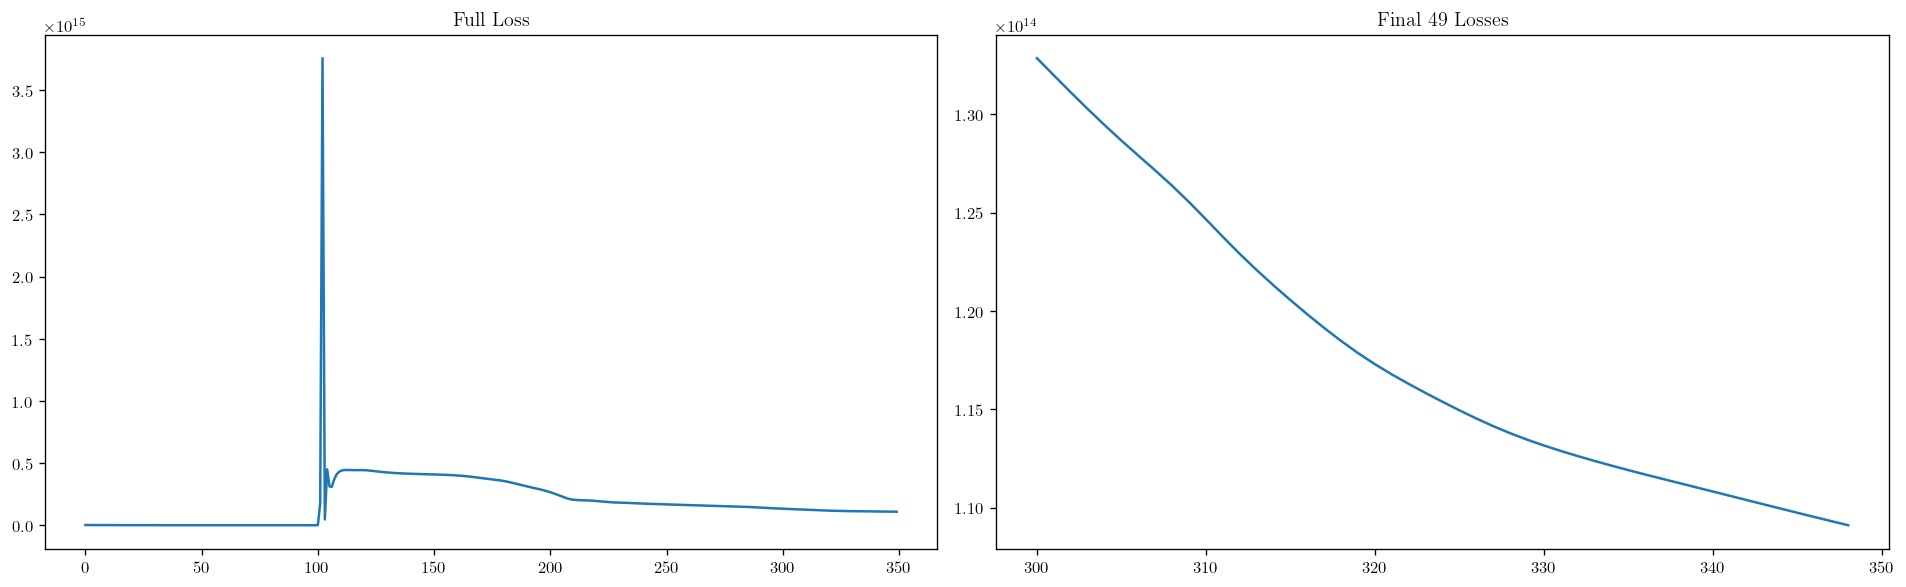

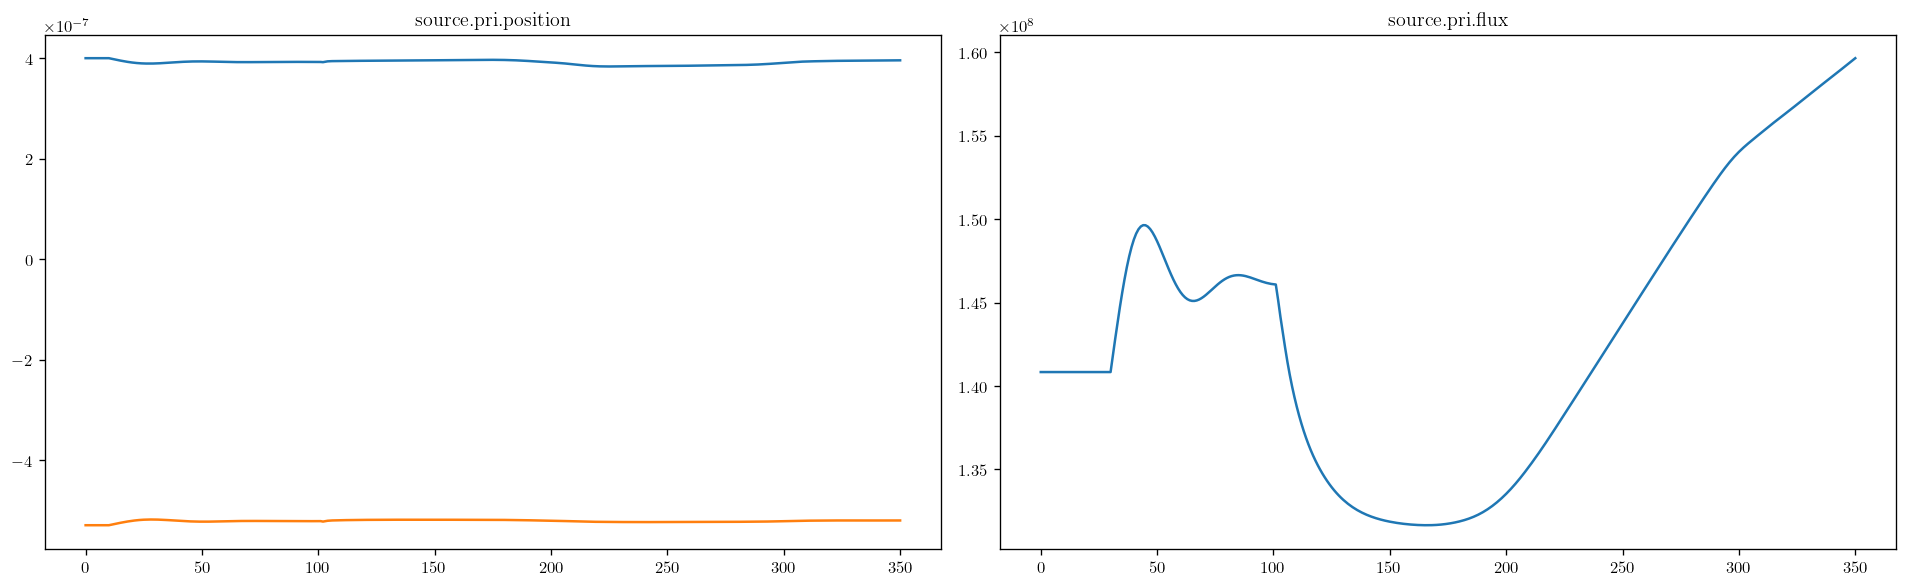

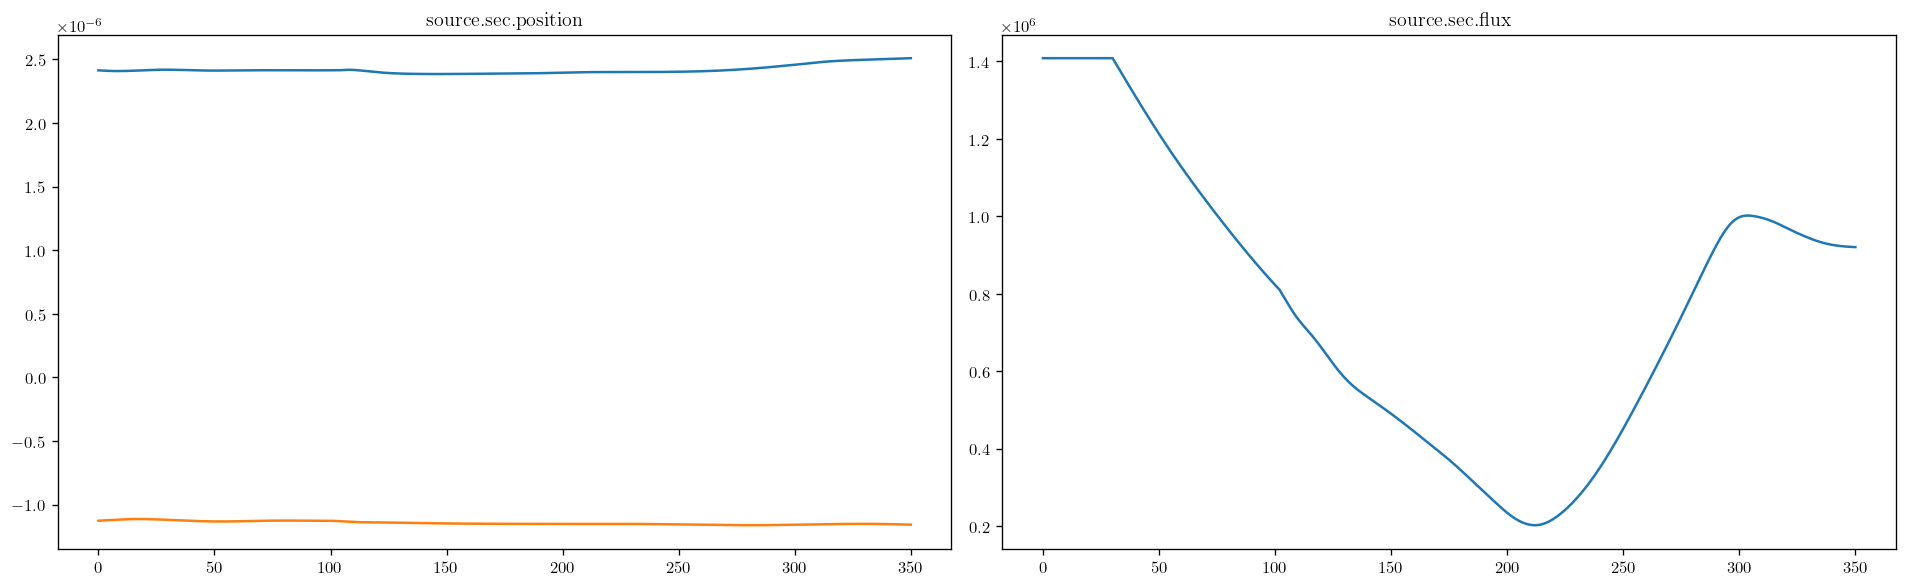

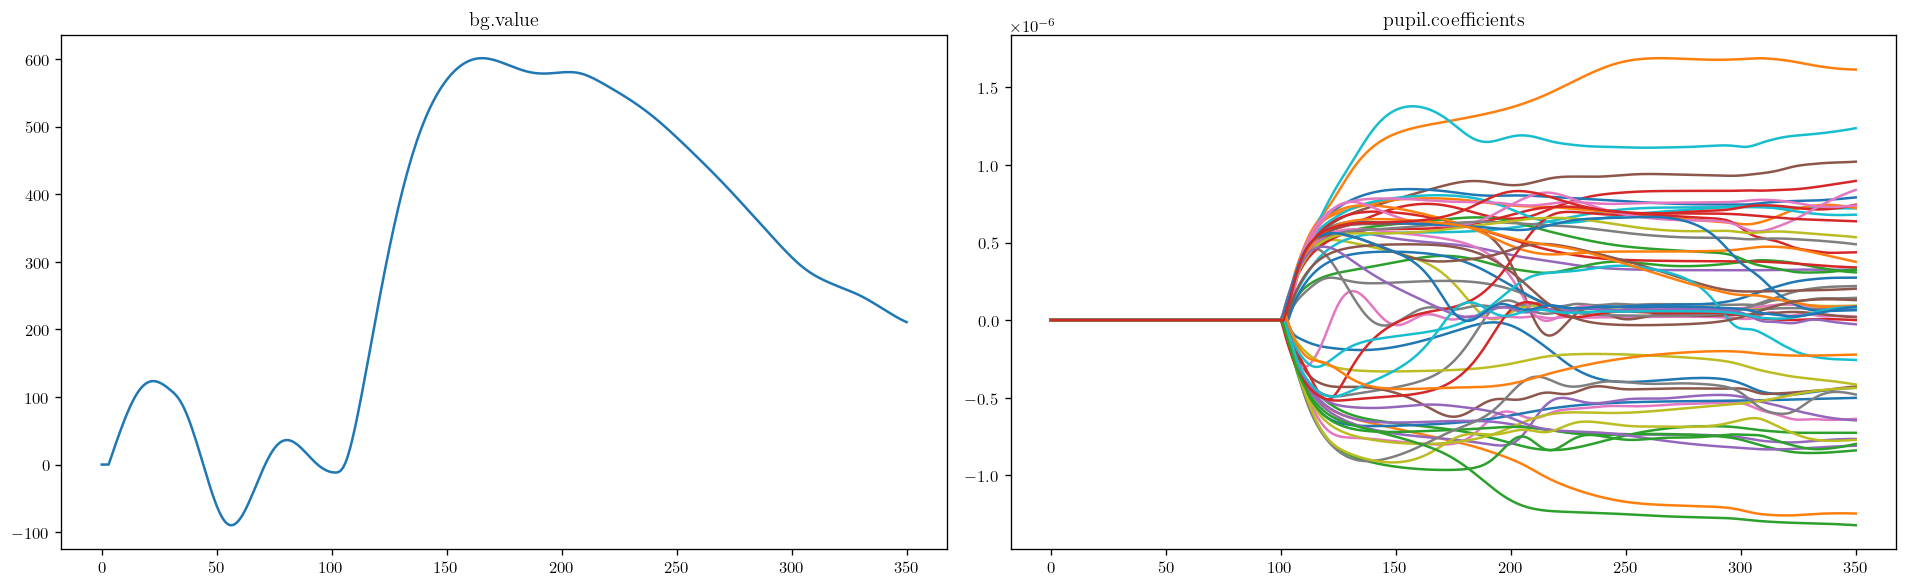

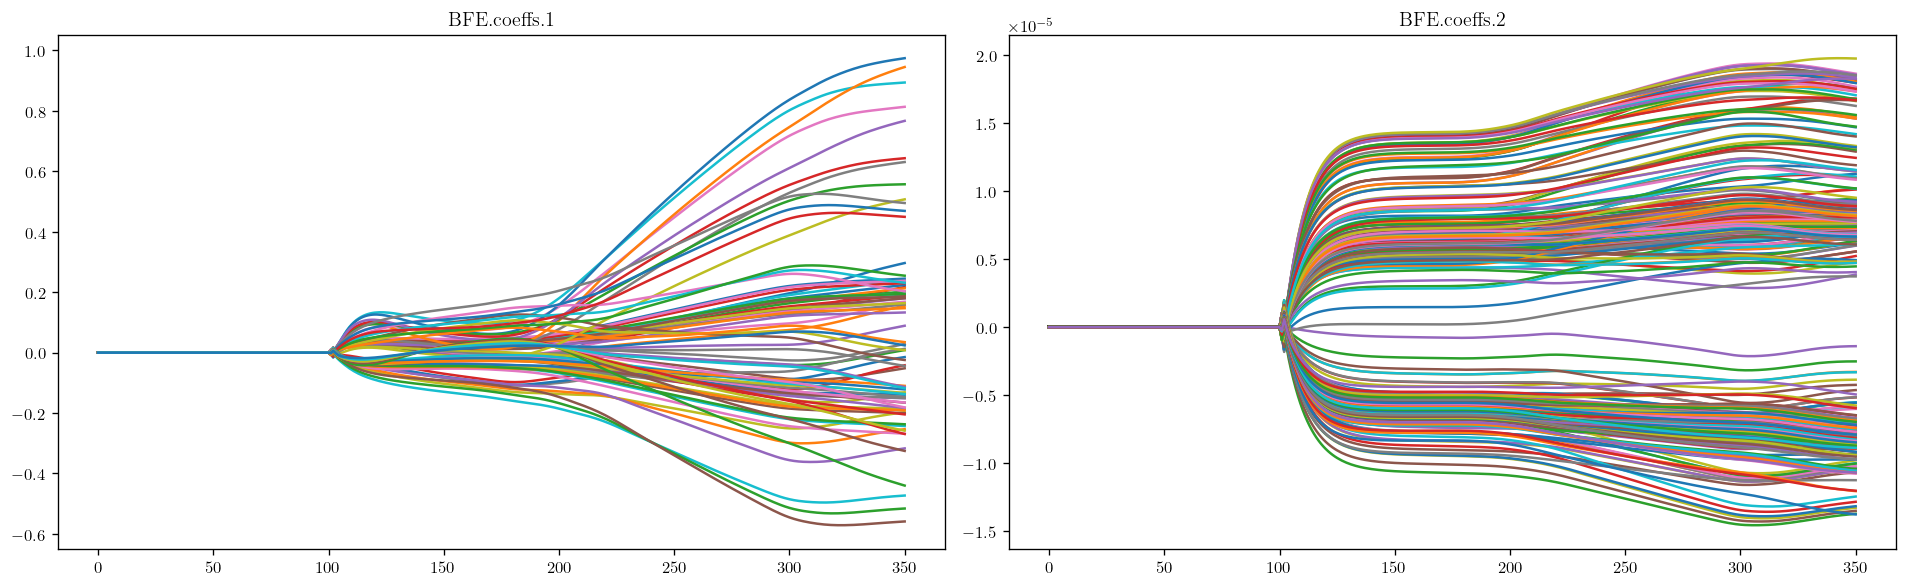

64


In [198]:
for fits_path in files[:1]:

    webbpsf_header, webbpsf_data_star, webbpsf_data_mask, webbpsf_data_err = read_fits(fits_path)

    npix = webbpsf_data_star.shape[0]
    webbpsf_data_flux = np.float64(np.sum(webbpsf_data_star))
    webbpsf_data_masked = webbpsf_data_star * webbpsf_data_mask

    key_names = ["TARGNAME", "DETECTOR", "FILTER", "PUPIL" ]
    target_key = ' '.join(list([webbpsf_header[k] for k in key_names]))

    grid_search_filename = os.path.join(pickle_dir, target_key + " GRID SEARCH DATA.bin")
    hmc_filename = os.path.join(pickle_dir, target_key + " HMC DATA.bin")
    pickle_file = os.path.join(pickle_dir, target_key + ".bin")

    # double_plot(webbpsf_data_masked, webbpsf_data_mask, target_key, os.path.join(ouput_path, target_key + ' 1 DATA'))
    # continue

    print('Creating model...', end="")

    #spectrum = SourceSpectrum(BlackBodyNorm1D, temperature=7500)

    telescope = get_telescope(npix,
                            webbpsf_header["FILTER"] if webbpsf_header["PUPIL"] == "CLEAR" else webbpsf_header["PUPIL"],
                            webbpsf_header['DETECTOR'].replace('LONG', '5'),
                            webbpsf_header['APERNAME'],
                            webbpsf_header['DATE-BEG'],
                            #pixel_mask = webbpsf_data_mask,
                            downsample = 4,
                            flux = webbpsf_data_flux,
                            #source=spectrum
                            )

    pixscale = toRad(telescope.psf_pixel_scale)

    def toPix(value):
        ret = (value / pixscale) + npix/2 - 0.5
        return ret
    
    print("ok")

    if os.path.isfile(grid_search_filename):
        with open(grid_search_filename, "rb") as f:
            grid_data = pickle.load(f)
    else:
        raise Exception("No grid search data, run grid search first")

    (pri_xr, pri_yr), (sec_xr, sec_yr) =  (grid_data['pri_x'], grid_data['pri_y']), (grid_data['sec_x'], grid_data['sec_y'])

    std = np.sqrt(webbpsf_data_star)
    std = np.where(std == 0, np.mean(std), std)

    im = webbpsf_data_star
    err = std

    im = nan_edges(im, 4)

    support_mask = ~np.isnan(im)
    support = np.where(support_mask)

    tel = telescope

    f = webbpsf_data_flux
    contrast = 100

    print(f'flux: {f}')

    model = tel
    model = model.set(['source.pri.position'], [np.array([pri_xr, pri_yr])])
    model = model.set(['source.sec.position'], [np.array([sec_xr, sec_yr])])

    model = model.set(['source.pri.flux', 'source.sec.flux'], [f, f/contrast])
    
    # TODO: Investigate adamw -> Decrease learning rate over time, should act as a
    # dampener, promoting convergence?
    delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s:1e16})
    config = {
        'source.pri.position':     optax.adam(delay(1e-9, 10)),
        'source.pri.flux':         optax.adam(delay(1e6, 30)),

        'source.sec.position':     optax.adam(delay(1e-9, 0)),
        'source.sec.flux':         optax.adam(delay(1e4, 30)),
        
        'bg.value':                optax.adam(delay(1e1, 3)),
        
        'pupil.coefficients':      optax.adam(delay(5e-8, 100)),

        #'BFE.coeffs.1':     optax.adam(delay(1e-2, 100)),
        #'BFE.coeffs.2':     optax.adam(delay(1e-6, 100)),

        #'OneOnF.coeffs':    optax.adam(delay(1e0, 50)),
        #'pupil.coefficients': optax.adam(delay(1e0, 50)),
    }

    spec = jtu.tree_map(lambda leaf: False, model).set(list(config.keys()), True)
    model, _model = eqx.partition(model, spec)

    # Loss function
    def loss_fn(model, args):
        '''Should the flux gradients out of this be scaled by the norm factor?'''
        # Get the arg values
        _model, data, err = args
        # Recombine the model
        model = eqx.combine(model, _model)

        model_data = model.model()[*support]
        residuals = data[*support] - model_data
        # calculate the chi-squared value
        chi_squared = np.sum(residuals**2)
        # calculate the likelihood
        likelihood =  0.5 * chi_squared
        return likelihood

    ############
    ############
    ############

    loss_fn_in = zdx.filter_jit(zdx.filter_value_and_grad(list(config.keys()))(loss_fn))

    # Optimisation
    print("Solving...")
    losses, models_out = fit_image(model, (_model, im, err), loss_fn_in, norm_fn, 350, config, print_grads=False)

    # Get the params from each model
    params_out = {}
    for param in config.keys():
        params_out[param] = [model.get(param) for model in models_out]

    final_model = eqx.combine(models_out[-1], _model)

    plot_params(np.array(losses), params_out, format_fn, k=300)

    psf_found = final_model.model()

    
    star_points = [
        (toArcsec(final_model.source.pri.position[0]), toArcsec(final_model.source.pri.position[1]), '*'),
        (toArcsec(final_model.source.sec.position[0]), toArcsec(final_model.source.sec.position[1]), '.')
    ]

    plot_residuals(webbpsf_data_star, psf_found, target_key + " GRAD SEARCH RESIDUALS", os.path.join(ouput_path, target_key + ' 2 GRAD SEARCH'), pixscale=telescope.psf_pixel_scale, points=star_points)
